##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [1]:
%pip install pandas 
%pip install matplotlib
%pip install pandas 
%pip install pyarrow
%pip install numpy
%pip install scikit-learn
%pip install imbalanced-learn
%pip install seaborn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [2]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [3]:
import pandas as pd
import numpy as np

df = pd.read_parquet("./data/catB_train.parquet")
df.head()
df.isna().sum()
thresh = 50

Setting a threshold at 50% indicates a balance between being too strict and too lenient. A lower threshold retains more complete rows but reduces the sample size, while a higher threshold may lead to a larger sample but with more missing information. Both cases would lead to less accurate results.

In [4]:

#removing columns with percentage of missing data exceeding the threshold
col = "race_desc"
print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
col = "ctrycode_desc"
print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
col = 'flg_gi_claim_29d435_ever'
print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
col = 'flg_gi_claim_058815_ever'
print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
col = 'flg_gi_claim_42e115_ever'
print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
col = 'flg_gi_claim_856320_ever'
print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
columns_to_delete = ['flg_gi_claim_29d435_ever','flg_gi_claim_058815_ever','flg_gi_claim_42e115_ever','flg_gi_claim_856320_ever']
df.drop(columns = columns_to_delete, inplace = True)


Column 'race_desc' is mostly empty: False
Column 'ctrycode_desc' is mostly empty: False
Column 'flg_gi_claim_29d435_ever' is mostly empty: True
Column 'flg_gi_claim_058815_ever' is mostly empty: True
Column 'flg_gi_claim_42e115_ever' is mostly empty: True
Column 'flg_gi_claim_856320_ever' is mostly empty: True


In [5]:
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)
#identifiy numeric columns and fill null values with the median value
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))
#find out which are the non-numeric cols
non_numeric_cols = df.select_dtypes(include=["string", "object"]).columns



In opting for the median to impute missing values, our rationale is rooted in the robustness of this measure when dealing with outliers and skewed distributions. The median's resistance to extreme values ensures a more reliable representation of central tendency, a critical consideration, especially for ordinal data with a meaningful order. Its suitability in handling skewed distributions makes the median a preferable choice over the mean in ensuring accuracy.

In [6]:
# to delete columns containing only 0s
df[numeric_cols].mean()[(df[numeric_cols].min() == 0) & (df[numeric_cols].max() == 0)].head()
# to find out which columns contained only 0s
df = df.drop(columns = ['is_dependent_in_at_least_1_policy','f_hold_d0adeb','f_hold_gi','f_ever_bought_d0adeb','f_ever_bought_ltc_1280bf'])
# detects and deletes columns with just one unique value 
for c in df.columns:
    if len(df[c].unique()) == 1:
        df = df.drop(columns = c)




We removed low-variance variables, as we felt that these factors will have little impact on the target class.

In [7]:
# Ordinal Encoding

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder 
# Identify non-numeric columns for ordinal encoding
categorical_columns = df.select_dtypes(include=['object','string']).columns

# Use OrdinalEncoder for ordinal encoding on non-numeric columns
ordinal_encoder = OrdinalEncoder()
df[categorical_columns] = ordinal_encoder.fit_transform(df[categorical_columns])

y = df["f_purchase_lh"]
X = df.drop(columns=['f_purchase_lh'])

Ordinal Encoding was chosen in place of One-Hot Encoding because One-Hot Encoding would not only enlarge the dataset, which would slow down the model training time, but it would also create a sparse dataset, resulting in the final result to be less accurate and precise

In [8]:
#SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

print('Before:', Counter(y_train))
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print('After:', Counter(y_train))

Before: Counter({0.0: 13809, 1.0: 584})
After: Counter({1.0: 13809, 0.0: 13809})


Reasons for not using downsampling and upsampling:

Downsampling involves reducing the amount of data, which can lead to a loss of information. It also involves rounding or truncating values, which can result in a loss of precision. This is particularly relevant when working with numerical data, and it can impact the accuracy of subsequent analyses or computations.

Upsampling often involves interpolation to estimate values between existing data points. The additional data points are estimates or interpolations of existing values, and they may not reflect the true characteristics of the underlying data.



In [9]:

#Decision Tree Model

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt_clf = DecisionTreeClassifier(max_leaf_nodes=10)
dt_clf.fit(X_train, y_train)

import matplotlib.pyplot as plt
plt.figure(figsize=(200, 50))
plot_tree(dt_clf, filled=True, feature_names=X_train.columns, class_names=df['f_purchase_lh'].unique().astype(str).tolist(), rounded=True)
plt.show()


From the decision tree, it can be observed that the most important factor affecting whether a customer will purchase life or health insurance products within the next three months is the purchase history of general insurance

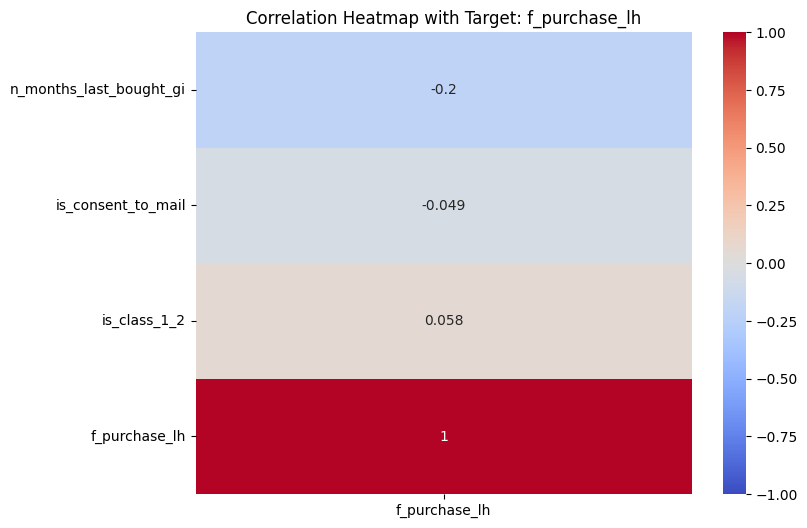

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a subset with the specified features and the target variable
subset = df[['n_months_last_bought_gi', 'is_consent_to_mail', 'is_class_1_2', 'f_purchase_lh']]

# Calculate the correlation matrix
correlation_matrix = subset.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix[['f_purchase_lh']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with Target: f_purchase_lh')
plt.show()

We picked the top three variables from the decision tree ( ie. those that will have a more significant impact on determining the target class), and created a heatmap, indicating the correlation between each of the three variables with the target class.

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89      2738
         1.0       0.91      0.85      0.88      2786

    accuracy                           0.88      5524
   macro avg       0.88      0.88      0.88      5524
weighted avg       0.89      0.88      0.88      5524



array([0.89106607, 0.88241349, 0.88418752, 0.87784163, 0.88826633])

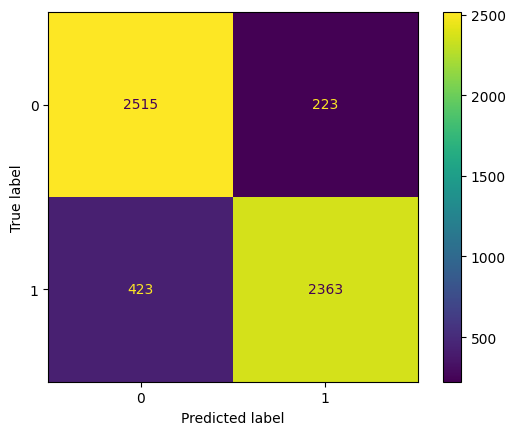

In [11]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Evaluate on validation set
y_val_pred = dt_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Code to generate visualisation of matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
disp.plot()

from sklearn.model_selection import cross_val_score

model = dt_clf
scores = cross_val_score(model, X_train, y_train, cv=5)

# By default, cross_val_score returns a numpy array of accurcacies for each train-test split
#>>> scores
#array([0.96..., 1. , 0.96..., 0.96..., 1. ])

# To use other metrics for example, f1-macro score:
from sklearn import metrics

scores = cross_val_score(model,X_train, y_train, cv=5, scoring='f1_macro')
scores


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


selected_features = [ 'n_months_last_bought_gi', 'is_consent_to_mail','is_class_1_2']

# Extract the selected features and target variable
X = df[selected_features]
y = df['f_purchase_lh']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_rep)

Accuracy: 0.7076261597646526
Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.76      0.72      2215
         1.0       0.73      0.65      0.69      2204

    accuracy                           0.71      4419
   macro avg       0.71      0.71      0.71      4419
weighted avg       0.71      0.71      0.71      4419



/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The decision tree returned a higher f1-score as compared to the logistic regression model, suggesting that the decision tree model performed better than the logistic regression model

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
boosted_clf = GradientBoostingClassifier()
boosted_clf.fit(X_train, y_train)
print("train accuracy: ", boosted_clf.score(X_train, y_train))
print("val accuracy: ", boosted_clf.score(X_val, y_val))

train accuracy:  0.9752192362093353
val accuracy:  0.9695872556118754


We chose to use gradient boosting as it could reduce the problem of overfitting, which may occur when the decision tree model is used

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [14]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    #DO NOT REMOVE THIS FUNCTION.

    #The function accepts a dataframe as input and return an iterable (list)
    #of binary classes as output.

    #The function should be coded to test on hidden data
    #and should include any preprocessing functions needed for your model to perform. 
    %pip install pandas 
    %pip install matplotlib
    %pip install pandas 
    %pip install pyarrow
    %pip install numpy
    %pip install scikit-learn
    %pip install imbalanced-learn
    %pip install seaborn
        
    # Can have as many cells as you want for code
    
    import pandas as pd
    filepath = "./data/catB_train.parquet" 
    # the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

    import pandas as pd
    import numpy as np

    df = pd.read_parquet("./data/catB_train.parquet")
    df.head()
    df.isna().sum()
    thresh = 50

    col = "race_desc"
    print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
    col = "ctrycode_desc"
    print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
    col = 'flg_gi_claim_29d435_ever'
    print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
    col = 'flg_gi_claim_058815_ever'
    print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
    col = 'flg_gi_claim_42e115_ever'
    print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
    col = 'flg_gi_claim_856320_ever'
    print(f"Column '{col}' is mostly empty:" , df[col].isna().sum()/df.shape[0]*100>thresh)
    columns_to_delete = ['flg_gi_claim_29d435_ever','flg_gi_claim_058815_ever','flg_gi_claim_42e115_ever','flg_gi_claim_856320_ever']
    df.drop(columns = columns_to_delete, inplace = True)

    df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)
    #identifiy numeric columns and fill null values with the median value
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))
    #Find out which are the non-numeric cols
    non_numeric_cols = df.select_dtypes(include=["string", "object"]).columns

    # to delete columns containing only 0s
    df[numeric_cols].mean()[(df[numeric_cols].min() == 0) & (df[numeric_cols].max() == 0)].head()
    # to find out which columns contained only 0s
    df = df.drop(columns = ['is_dependent_in_at_least_1_policy','f_hold_d0adeb','f_hold_gi','f_ever_bought_d0adeb','f_ever_bought_ltc_1280bf'])
    # detects and deletes columns with just one unique value 
    for c in df.columns:
        if len(df[c].unique()) == 1:
            df = df.drop(columns = c)

    # Ordinal Encoding

    from sklearn.preprocessing import OrdinalEncoder, LabelEncoder 
    # Identify non-numeric columns for ordinal encoding
    categorical_columns = df.select_dtypes(include=['object','string']).columns

    # Use OrdinalEncoder for ordinal encoding on non-numeric columns
    ordinal_encoder = OrdinalEncoder()
    df[categorical_columns] = ordinal_encoder.fit_transform(df[categorical_columns])

    y = df["f_purchase_lh"]
    X = df.drop(columns=['f_purchase_lh'])

    #SMOTE
    from collections import Counter
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

    print('Before:', Counter(y_train))
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    print('After:', Counter(y_train))

    #Decision Tree Model
    from sklearn.model_selection import train_test_split

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    from sklearn.tree import DecisionTreeClassifier, plot_tree

    dt_clf = DecisionTreeClassifier(max_leaf_nodes=10)
    dt_clf.fit(X_train, y_train)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(200, 50))
    plot_tree(dt_clf, filled=True, feature_names=X_train.columns, class_names=df['f_purchase_lh'].unique().astype(str).tolist(), rounded=True)
    plt.show()

    #Heatmap
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Create a subset with the specified features and the target variable
    subset = df[['n_months_last_bought_gi', 'is_consent_to_mail', 'is_class_1_2', 'f_purchase_lh']]

    # Calculate the correlation matrix
    correlation_matrix = subset.corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix[['f_purchase_lh']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap with Target: f_purchase_lh')
    plt.show()

    #Cross Validation
    from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

    # Evaluate on validation set
    y_val_pred = dt_clf.predict(X_val)
    print(classification_report(y_val, y_val_pred))

    # Code to generate visualisation of matrix
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,) # set display_label according to dataset
    disp.plot()


    from sklearn.model_selection import cross_val_score

    model = dt_clf
    scores = cross_val_score(model, X_train, y_train, cv=5)

    # By default, cross_val_score returns a numpy array of accurcacies for each train-test split
    #>>> scores
    #array([0.96..., 1. , 0.96..., 0.96..., 1. ])

    # To use other metrics for example, f1-macro score:
    from sklearn import metrics

    scores = cross_val_score(model,X_train, y_train, cv=5, scoring='f1_macro')
    scores

    #Gradient Boosting Classifier
    from sklearn.ensemble import GradientBoostingClassifier
    boosted_clf = GradientBoostingClassifier()
    boosted_clf.fit(X_train, y_train)
    print("train accuracy: ", boosted_clf.score(X_train, y_train))
    print("val accuracy: ", boosted_clf.score(X_val, y_val))

   #All relevant code MUST be included in this function.
    result = [] 
    return result

We tried both Decision Tree Model and Logistic Regression and discovered that Decision Tree Model gave a better result, which will be the one that is used for testing with the hidden data.

##### Cell to check testing_hidden_data function

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Column 'race_desc' is mostly empty: False
Column 'ctrycode_desc' is mostly empty: False
Column 'flg_gi_claim_29d435_ever' is mostly empty: True
Column 'flg_gi_claim_058815_ever' is mostly empty: True
Column 'flg_gi_claim_42e115_ever' is mostly empty: True
Column 'flg_gi_claim_856320_ever' is mostly empty: True
Before: Counter({0.0: 13809, 1.0: 584})
After: Counter({1.0: 13809, 0.0: 13809})


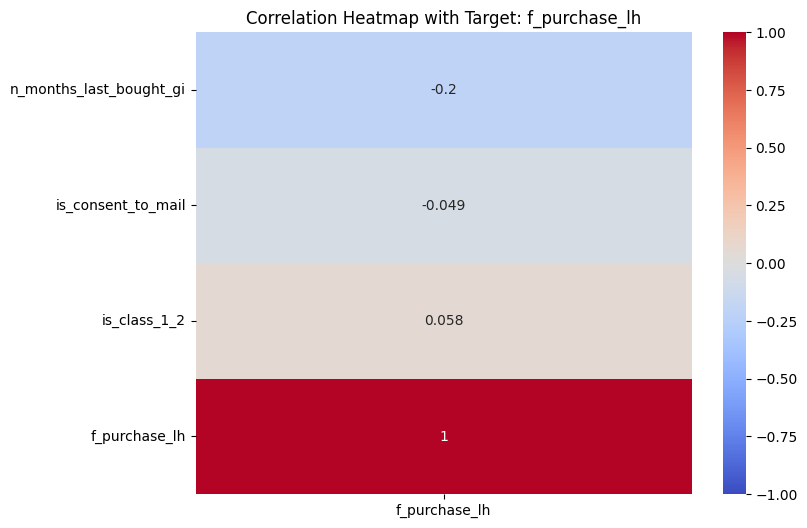

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89      2738
         1.0       0.91      0.85      0.88      2786

    accuracy                           0.88      5524
   macro avg       0.89      0.88      0.88      5524
weighted avg       0.89      0.88      0.88      5524

train accuracy:  0.9746537521499049
val accuracy:  0.9724837074583635
[]


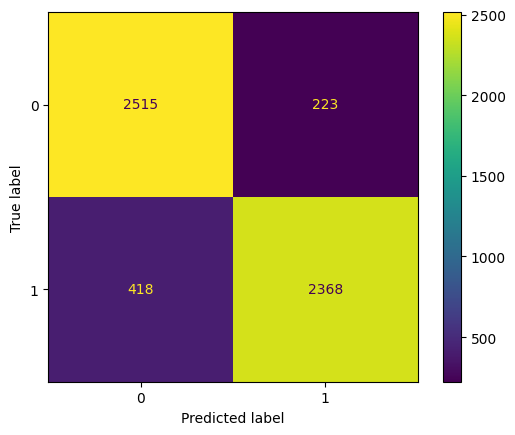

In [15]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!